In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway
from statannotations.Annotator import Annotator
from itertools import combinations

In [5]:
df_food = pd.read_csv("df_food_filtered_with_food_group.csv",index_col=0)
with open("df_food_openfoodfacts_merged.pkl", "rb") as f:
    df_food_openfoodfacts = pickle.load(f, encoding="latin1")

C:\Users\Sophie\AppData\Local\Temp\ipykernel_19476\1585345951.py:1: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food = pd.read_csv("df_food_filtered_with_food_group.csv",index_col=0)


In [125]:
df_food = df_food[df_food["eaten_quantity_in_gram"] > 0]
df_food = df_food[df_food["energy_kcal_eaten"] > 0]

In [185]:
nutrient_info = {
    'folate_eaten':                                         {'unit': 'mcg', 'target': 400,  'type': 'qualifying'},
    'niacin_eaten':                                         {'unit': 'mg',  'target': 14,   'type': 'qualifying'},
    'pantothenic_acid_eaten':                               {'unit': 'mg',  'target': 5,    'type': 'qualifying'},
    'vitamin_b2_eaten':                                     {'unit': 'mg',  'target': 1.1,  'type': 'qualifying'},
    'vitamin_b1_eaten':                                     {'unit': 'mg',  'target': 1.2,  'type': 'qualifying'},
    'all_trans_retinol_equivalents_activity_eaten':         {'unit': 'IU',  'target': 700,  'type': 'qualifying'},
    'beta_carotene_eaten':                                  {'unit' : 'mcg','target' : 700, 'type' :'qualifying'},
    'vitamin_b12_eaten':                                    {'unit': 'mcg', 'target': 2.4,  'type': 'qualifying'},
    'vitamin_b6_eaten':                                     {'unit': 'mg',  'target': 1.3,  'type': 'qualifying'},
    'vitamin_c_eaten':                                      {'unit': 'mg',  'target': 75,   'type': 'qualifying'},
    'vitamin_d_eaten':                                      {'unit': 'mcg', 'target': 7.5,  'type': 'qualifying'},
    'vitamin_e_activity_eaten':                             {'unit': 'TAE', 'target': 15,    'type': 'qualifying'},
    'calcium_eaten':                                        {'unit': 'mg',  'target': 1000, 'type': 'qualifying'},
    'iron_eaten':                                           {'unit': 'mg',  'target': 18,   'type': 'qualifying'},
    'magnesium_eaten':                                      {'unit': 'mg',  'target': 320,  'type': 'qualifying'},
    'phosphorus_eaten':                                     {'unit': 'mg',  'target': 700,  'type': 'qualifying'},
    'potassium_eaten':                                      {'unit': 'mg',  'target': 4700, 'type': 'qualifying'},
    'zinc_eaten':                                           {'unit': 'mg',  'target': 8,    'type': 'qualifying'},
    'fiber_eaten':                                          {'unit': 'g',   'target': 25,   'type': 'qualifying'},
    'protein_eaten':                                        {'unit': 'g',   'target': 46,   'type': 'qualifying'},
    'fat_eaten':                                            {'unit': 'g',   'target': 78,   'type': 'disqualifying'},
    'fatty_acids_saturated_eaten':                          {'unit': 'g',   'target': 22,   'type': 'disqualifying'},
    'cholesterol_eaten':                                    {'unit': 'mg',  'target': 300,  'type': 'disqualifying'},
    'sugar_eaten':                                          {'unit': 'g',   'target': 125,  'type': 'disqualifying'},
    'sodium_eaten':                                         {'unit': 'mg',  'target': 2400, 'type': 'disqualifying'},
    'salt_eaten' :                                          {'unit' : 'g',  'target': 6,   'type': 'disqualifying'}
}


conversion_factors = {
    "mg": 1000,
    "g": 1,
    "mcg": 1000000,
    "IU": 1,
    "TAE": 1,
}

In [127]:
qualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'qualifying'}
disqualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'disqualifying'}

In [155]:
def convert_to_grams(nutrient_info, conversion_factors) :
    

    for nutr, info in nutrient_info.items():

        factor = conversion_factors.get(info['unit'], 1)
        target_in_gram = info['target'] / factor 

        info['target_in_gram'] = target_in_gram

    return nutrient_info

In [184]:
nutrient_info = convert_to_grams(nutrient_info, conversion_factors)

In [131]:
def calculate_ratios(df, nutrient_cols):
    df = df.copy()

    for nutr in nutrient_cols:
        df[nutr + '_ratio'] = df[nutr] / nutrient_info[nutr]['target_in_gram']

    return df

df_food_ratio = calculate_ratios(df_food.fillna(0), list(nutrient_info.keys()))

In [136]:
df_food_ratio

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,potassium_eaten_ratio,zinc_eaten_ratio,fiber_eaten_ratio,protein_eaten_ratio,fat_eaten_ratio,fatty_acids_saturated_eaten_ratio,cholesterol_eaten_ratio,sugar_eaten_ratio,sodium_eaten_ratio,salt_eaten_ratio
0,13,0,335994,110.00,g,bjsqab,2022-02-15 18:06:27,60,1,dairy_products_meat_fish_eggs_tofu,...,0.070213,0.591250,0.00000,0.650435,0.063462,0.085000,0.322667,0.00000,0.035292,0.000000
3,13,0,411384,100.00,g,erv9jd,2023-01-18 13:08:53,60,1,dairy_products_meat_fish_eggs_tofu,...,0.063830,0.537500,0.00000,0.591304,0.057692,0.077273,0.293333,0.00000,0.032083,0.000000
4,25,0,202497,35.00,g,6ata8r,2021-03-30 13:52:23,120,1,vegetables_fruits,...,0.009681,0.004375,0.01960,0.003043,0.000897,0.000000,0.000000,0.03164,0.000292,0.000000
5,25,0,283397,35.00,g,uzbc9s,2021-10-21 10:09:09,120,1,vegetables_fruits,...,0.009681,0.004375,0.01960,0.003043,0.000897,0.000000,0.000000,0.03164,0.000292,0.000000
6,25,0,266679,40.00,g,fvh6kf,2021-09-19 10:14:35,120,1,vegetables_fruits,...,0.011064,0.005000,0.02240,0.003478,0.001026,0.000000,0.000000,0.03616,0.000333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514955,46573,4104420237155,426463,16.00,g,pgeyqb,2023-03-13 15:16:39,60,0,unclassified,...,0.000000,0.000000,0.02688,0.027826,0.006154,0.008000,0.000000,0.01920,0.000000,0.000800
514956,46573,4104420237155,426838,16.00,g,pgeyqb,2023-03-13 15:30:54,60,0,unclassified,...,0.000000,0.000000,0.02688,0.027826,0.006154,0.008000,0.000000,0.01920,0.000000,0.000800
514957,46575,5411188102809,423445,100.00,g,kmxhmz,2023-02-25 08:18:11,60,1,unclassified,...,0.000000,0.000000,0.04800,0.078261,0.025641,0.013636,0.000000,0.07520,0.000000,0.035000
514958,46588,7618500940806,425332,100.00,ml,pgeyqb,2023-03-06 18:31:08,60,1,unclassified,...,0.000000,0.000000,0.00000,0.013043,0.000000,0.000000,0.000000,0.03200,0.000000,0.166667


In [143]:
def compute_index(row, nutrient_cols, scaling_factor=2000) :

    index = 0
    ratio_sum = 0

    for nutr in nutrient_cols :
        ratio_sum += row[nutr + '_ratio']

    index = (scaling_factor / row['energy_kcal_eaten']) * (ratio_sum / len(nutrient_cols))
    return index



In [162]:
def compute_nb(row, nutrient_cols, scaling_factor=2000) :
    truncated_ratios = []
    for nutr in nutrient_cols:
        ratio = (scaling_factor / row['energy_kcal_eaten'])  * row[nutr + '_ratio']
        if ratio > 1.0 :
            ratio = 1
        truncated_ratios.append(ratio)

    nb_value = (sum(truncated_ratios) / len(nutrient_cols)) * 100
    return nb_value

In [140]:
df_food_ratio['QI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=qualifying_nutrients)


In [145]:
df_food_ratio['DI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=disqualifying_nutrients)

In [163]:
df_food_ratio['NB'] = df_food_ratio.apply(compute_nb, axis=1, nutrient_cols=qualifying_nutrients)

In [164]:
df_food_ratio

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,protein_eaten_ratio,fat_eaten_ratio,fatty_acids_saturated_eaten_ratio,cholesterol_eaten_ratio,sugar_eaten_ratio,sodium_eaten_ratio,salt_eaten_ratio,QI,DI,NB
0,13,0,335994,110.00,g,bjsqab,2022-02-15 18:06:27,60,1,dairy_products_meat_fish_eggs_tofu,...,0.650435,0.063462,0.085000,0.322667,0.00000,0.035292,0.000000,2.498497,1.029937,67.110660
3,13,0,411384,100.00,g,erv9jd,2023-01-18 13:08:53,60,1,dairy_products_meat_fish_eggs_tofu,...,0.591304,0.057692,0.077273,0.293333,0.00000,0.032083,0.000000,2.498497,1.029937,67.110660
4,25,0,202497,35.00,g,6ata8r,2021-03-30 13:52:23,120,1,vegetables_fruits,...,0.003043,0.000897,0.000000,0.000000,0.03164,0.000292,0.000000,1.047794,0.613055,61.770389
5,25,0,283397,35.00,g,uzbc9s,2021-10-21 10:09:09,120,1,vegetables_fruits,...,0.003043,0.000897,0.000000,0.000000,0.03164,0.000292,0.000000,1.047794,0.613055,61.770389
6,25,0,266679,40.00,g,fvh6kf,2021-09-19 10:14:35,120,1,vegetables_fruits,...,0.003478,0.001026,0.000000,0.000000,0.03616,0.000333,0.000000,1.047794,0.613055,61.770389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514955,46573,4104420237155,426463,16.00,g,pgeyqb,2023-03-13 15:16:39,60,0,unclassified,...,0.027826,0.006154,0.008000,0.000000,0.01920,0.000000,0.000800,0.090215,0.187741,9.021452
514956,46573,4104420237155,426838,16.00,g,pgeyqb,2023-03-13 15:30:54,60,0,unclassified,...,0.027826,0.006154,0.008000,0.000000,0.01920,0.000000,0.000800,0.090215,0.187741,9.021452
514957,46575,5411188102809,423445,100.00,g,kmxhmz,2023-02-25 08:18:11,60,1,unclassified,...,0.078261,0.025641,0.013636,0.000000,0.07520,0.000000,0.035000,0.952744,0.682545,30.000000
514958,46588,7618500940806,425332,100.00,ml,pgeyqb,2023-03-06 18:31:08,60,1,unclassified,...,0.013043,0.000000,0.000000,0.000000,0.03200,0.000000,0.166667,0.786561,3.010101,10.000000


In [165]:
df_food_ratio[['QI', 'DI', 'NB', 'combined_name', 'food_group']].groupby('food_group').median(numeric_only=True).sort_values('QI')

,QI,DI,NB
food_group,,,
alcoholic_beverages,0.038127,0.007668,3.812709
sweetened_beverages,0.041806,0.664300,4.180602
others,0.105016,0.666667,5.474351
soups_sauces_condiments,0.117561,1.068889,6.402525
salty_snacks,0.121828,0.535766,10.000000
cooked_grains_pasta,0.135563,0.517566,9.358974
sweets_desserts,0.157373,0.852030,12.639102
vegetable_oils,0.245871,0.694173,6.645221
butter_margarine_spreads,0.284294,1.837749,15.794434


In [171]:
df_vegetable = df_food_ratio[df_food_ratio['food_group'] == 'vegetables']

In [174]:
df_vegetable.drop_duplicates('combined_name')

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,protein_eaten_ratio,fat_eaten_ratio,fatty_acids_saturated_eaten_ratio,cholesterol_eaten_ratio,sugar_eaten_ratio,sodium_eaten_ratio,salt_eaten_ratio,QI,DI,NB
126,50,0,4055,40.0,g,k3pnhy,2019-02-14 18:57:30,60,1,vegetables_fruits,...,0.016522,0.000513,0.000000,0.0,0.033600,0.009667,0.000000,1.679289,0.640051,69.928989
1066,116,0,100802,25.0,g,upybs2,2020-03-12 18:29:00,60,1,vegetables_fruits,...,0.015761,0.001282,0.001136,0.0,0.004400,0.001146,0.000000,10.154847,0.353967,85.000000
1529,143,0,261362,100.0,g,dradpm,2021-09-06 10:46:40,120,1,vegetables_fruits,...,0.019565,0.003846,0.000000,0.0,0.056800,0.010417,0.000000,26.262483,0.577747,80.530812
2440,148,0,83560,60.0,g,r2wkvx,2019-12-07 21:34:54,60,1,vegetables_fruits,...,0.013043,0.000769,0.000000,0.0,0.007680,0.025000,0.000000,9.101358,1.161432,85.000000
2454,150,0,209797,40.0,g,jb3nq3,2021-04-18 17:09:04,120,1,vegetables_fruits,...,0.013913,0.001538,0.000000,0.0,0.006400,0.014167,0.000000,3.910093,0.614031,85.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513903,33127,7627534181055,385720,52.0,g,kgbtut,2022-09-20 16:42:32,120,0,unclassified,...,0.026000,0.013333,0.011818,0.0,0.028704,0.000000,0.043333,0.204938,0.769143,10.000000
513969,33189,7613312295588,388048,250.0,g,kgbtut,2022-09-26 16:53:22,120,0,unclassified,...,0.059783,0.016026,0.000000,0.0,0.028000,0.000000,0.270833,0.471118,1.499328,10.000000
514352,33518,7627534612115,397015,200.0,g,wjtpa5,2022-11-06 21:49:57,60,0,unclassified,...,0.052174,0.000000,0.000000,0.0,0.016000,0.000000,0.000000,0.684058,0.222222,10.000000
514667,46071,7613312273760,406384,250.0,g,48wbxy,2022-12-08 11:09:58,60,0,unclassified,...,0.277174,0.041667,0.022727,0.0,0.062000,0.000000,0.191667,0.377753,0.550754,10.000000


In [175]:
df_vegetable.drop_duplicates('combined_name').sort_values('QI', ascending=False)[['combined_name', 'QI', 'DI', 'NB']].head(30)

,combined_name,QI,DI,NB
484235,Epinards,40.795386,0.613869,85.000000
4599,"Spinach, raw",40.795386,0.613869,85.000000
485667,Coop Naturaplan Betty Bossi Organic mung bean ...,39.742825,1.335664,80.000000
4426,"Chicory, steamed, without addition of salt",37.913804,0.210058,84.761905
26934,Cress,36.840014,0.856397,85.000000
4453,"Spinach, steamed, without addition of salt",35.562131,0.539693,85.000000
472765,Bio Karotten Schweizer,32.681048,0.572643,82.154882
463795,Coop Naturaplan Grated carrot,32.681048,0.690236,82.154882
34611,"Salad, lambs' ear",31.008325,0.396237,83.478261
499389,Coop Qualité&Prix - Nüsslisalat Schweiz,31.008325,0.396237,83.478261


In [181]:
df_vegetable[df_vegetable['combined_name'] == 'Epinards'][[i for i in df_vegetable.columns if '_eaten_ratio' in i]].T

,484235,484236
folate_eaten_ratio,0.237500,0.237500
niacin_eaten_ratio,0.025000,0.025000
pantothenic_acid_eaten_ratio,0.020000,0.020000
vitamin_b2_eaten_ratio,0.100000,0.100000
vitamin_b1_eaten_ratio,0.041667,0.041667
all_trans_retinol_equivalents_activity_eaten_ratio,0.000000,0.000000
beta_carotene_eaten_ratio,3.435714,3.435714
vitamin_b12_eaten_ratio,0.000000,0.000000
vitamin_b6_eaten_ratio,0.076923,0.076923
vitamin_c_eaten_ratio,0.266667,0.266667


In [183]:
df_vegetable[df_vegetable['combined_name'] == 'Epinards']['energy_kcal_eaten']

484235    11.5
484236    11.5
Name: energy_kcal_eaten, dtype: float64

## Beta Carotene

In [79]:
high_beta_carotene = df_vegetable[df_vegetable['beta_carotene_eaten_scaled'] > 700]
high_beta_carotene.drop_duplicates('combined_name')

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,protein_eaten_scaled,fat_eaten_scaled,fatty_acids_saturated_eaten_scaled,cholesterol_eaten_scaled,sugar_eaten_scaled,sodium_eaten_scaled,salt_eaten_scaled,QI,DI,NB
1066,116,0,100802,25.0,g,upybs2,2020-03-12 18:29:00,60,1,vegetables_fruits,...,193.333333,26.666667,6.666667,0.0,146.666667,733.333333,0.0,10.154847,0.353967,85.000000
1529,143,0,261362,100.0,g,dradpm,2021-09-06 10:46:40,120,1,vegetables_fruits,...,43.902439,14.634146,0.000000,0.0,346.341463,1219.512195,0.0,26.262483,0.577747,80.530812
2440,148,0,83560,60.0,g,r2wkvx,2019-12-07 21:34:54,60,1,vegetables_fruits,...,125.000000,12.500000,0.000000,0.0,200.000000,12500.000000,0.0,9.101358,1.161432,85.000000
2454,150,0,209797,40.0,g,jb3nq3,2021-04-18 17:09:04,120,1,vegetables_fruits,...,106.666667,20.000000,0.000000,0.0,133.333333,5666.666667,0.0,3.910093,0.614031,85.000000
2504,158,0,219256,70.0,g,2s5nv7,2021-05-03 17:05:04,120,1,vegetables_fruits,...,187.096774,32.258065,6.451613,0.0,12.903226,329.032258,0.0,9.992284,0.157857,86.655914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497082,11993,7617027953481,153190,71.5,g,hz8bqs,2020-10-14 10:16:41,120,0,vegetables_fruits,...,233.333333,27.777778,5.555556,0.0,11.111111,283.333333,0.0,8.682969,0.135933,85.731481
499389,13077,7613356746046,174540,66.0,g,gc2pge,2021-01-11 12:25:41,60,0,vegetables_fruits,...,173.913043,34.782609,8.695652,0.0,173.913043,347.826087,0.0,31.008325,0.396237,83.478261
499423,13116,7613269978756,174807,75.0,g,n2y4ks,2021-01-13 11:30:19,60,0,vegetables_fruits,...,171.428571,28.571429,0.000000,0.0,142.857143,328.571429,0.0,16.450265,0.274344,85.000000
499520,13186,7613404116067,176014,150.0,g,n2y4ks,2021-01-19 11:50:58,60,0,vegetables_fruits,...,76.190476,28.571429,0.000000,0.0,304.761905,152.380952,0.0,6.940569,0.477981,84.047619


In [80]:
high_beta_carotene.drop_duplicates('combined_name').sort_values('QI', ascending=False)

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,protein_eaten_scaled,fat_eaten_scaled,fatty_acids_saturated_eaten_scaled,cholesterol_eaten_scaled,sugar_eaten_scaled,sodium_eaten_scaled,salt_eaten_scaled,QI,DI,NB
484235,8436,7617027876896,80922,50.0,g,9hfx6d,2019-11-21 11:50:28,60,0,vegetables_fruits,...,234.782609,34.782609,8.695652,0.0,60.869565,5652.173913,0.000000,40.795386,0.613869,85.000000
4599,282,0,133095,35.0,g,ufhzdw,2020-06-27 17:45:54,120,1,vegetables_fruits,...,234.782609,34.782609,8.695652,0.0,60.869565,5652.173913,0.000000,40.795386,0.613869,85.000000
485667,8765,7610849119226,87480,100.0,g,hf2bxs,2020-01-16 13:50:38,60,1,grains_potatoes_pulses,...,192.307692,0.000000,115.384615,0.0,269.230769,553.846154,2.307692,39.742825,1.335664,80.000000
4426,279,0,113961,80.0,g,8vtq3c,2020-04-29 10:37:12,120,1,vegetables_fruits,...,142.857143,28.571429,0.000000,0.0,85.714286,500.000000,0.000000,37.913804,0.210058,84.761905
26934,1035,0,1251,20.0,g,2yj8gb,2018-12-03 10:53:43,60,1,vegetables_fruits,...,258.823529,23.529412,11.764706,0.0,35.294118,4941.176471,11.764706,36.840014,0.856397,85.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488571,9502,7610200012081,103099,40.0,g,7cfcj9,2020-03-23 17:48:43,60,0,vegetables_fruits,...,49.586777,24.793388,8.264463,0.0,41.322314,4958.677686,8.264463,0.977845,0.744604,67.938280
111735,1228,0,172577,20.0,g,ce7tss,2020-12-18 16:59:13,60,1,vegetables_fruits,...,20.634921,198.412698,28.571429,0.0,0.000000,25555.555556,63.492063,0.855014,4.178769,44.411926
463820,4839,7640128539353.0,205394,50.0,g,nbgbv4,2021-04-08 10:46:53,120,1,vegetables_fruits,...,142.857143,14.285714,0.714286,0.0,17.142857,26.428571,0.000000,0.754386,0.060629,51.988851
494121,10840,7613269770688,132154,60.0,g,8whq7a,2020-06-23 17:47:33,120,0,vegetables_fruits,...,19.157088,206.896552,45.977011,0.0,3.831418,12337.164751,30.651341,0.373718,2.503680,26.937592


In [81]:
a = high_beta_carotene.drop_duplicates('combined_name')[[i for i in df_vegetable.columns if '_eaten_scaled' in i]]
a

,folate_eaten_scaled,niacin_eaten_scaled,pantothenic_acid_eaten_scaled,vitamin_b2_eaten_scaled,vitamin_b1_eaten_scaled,all_trans_retinol_equivalents_activity_eaten_scaled,beta_carotene_eaten_scaled,vitamin_b12_eaten_scaled,vitamin_b6_eaten_scaled,vitamin_c_eaten_scaled,...,potassium_eaten_scaled,zinc_eaten_scaled,fiber_eaten_scaled,protein_eaten_scaled,fat_eaten_scaled,fatty_acids_saturated_eaten_scaled,cholesterol_eaten_scaled,sugar_eaten_scaled,sodium_eaten_scaled,salt_eaten_scaled
1066,4200.000000,51.333333,49.333333,7.333333,5.333333,0.0,31733.333333,0.0,10.666667,5286.666667,...,20000.000000,26.666667,193.333333,193.333333,26.666667,6.666667,0.0,146.666667,733.333333,0.0
1529,975.609756,25.853659,9.268293,2.439024,4.390244,0.0,341414.634146,0.0,7.317073,302.439024,...,7317.073171,4.878049,141.463415,43.902439,14.634146,0.000000,0.0,346.341463,1219.512195,0.0
2440,1375.000000,42.500000,45.000000,5.000000,5.000000,0.0,68250.000000,0.0,7.500000,800.000000,...,33750.000000,12.500000,262.500000,125.000000,12.500000,0.000000,0.0,200.000000,12500.000000,0.0
2454,1733.333333,45.333333,30.000000,4.000000,2.666667,0.0,4133.333333,0.0,10.000000,453.333333,...,19333.333333,26.666667,353.333333,106.666667,20.000000,0.000000,0.0,133.333333,5666.666667,0.0
2504,1419.354839,380.645161,174.193548,20.645161,5.161290,0.0,11483.870968,0.0,4.516129,258.064516,...,31612.903226,64.516129,387.096774,187.096774,32.258065,6.451613,0.0,12.903226,329.032258,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497082,1222.222222,327.777778,150.000000,17.777778,4.444444,0.0,9888.888889,0.0,3.888889,222.222222,...,27222.222222,55.555556,333.333333,233.333333,27.777778,5.555556,0.0,11.111111,283.333333,0.0
499389,7078.260870,34.782609,3.478261,7.826087,6.086957,0.0,344347.826087,0.0,23.478261,2113.043478,...,40000.000000,43.478261,147.826087,173.913043,34.782609,8.695652,0.0,173.913043,347.826087,0.0
499423,5285.714286,57.142857,15.714286,11.428571,8.571429,0.0,161428.571429,0.0,8.571429,971.428571,...,20000.000000,28.571429,228.571429,171.428571,28.571429,0.000000,0.0,142.857143,328.571429,0.0
499520,2285.714286,57.142857,28.571429,3.809524,5.714286,0.0,41142.857143,0.0,7.619048,1961.904762,...,20952.380952,9.523810,114.285714,76.190476,28.571429,0.000000,0.0,304.761905,152.380952,0.0


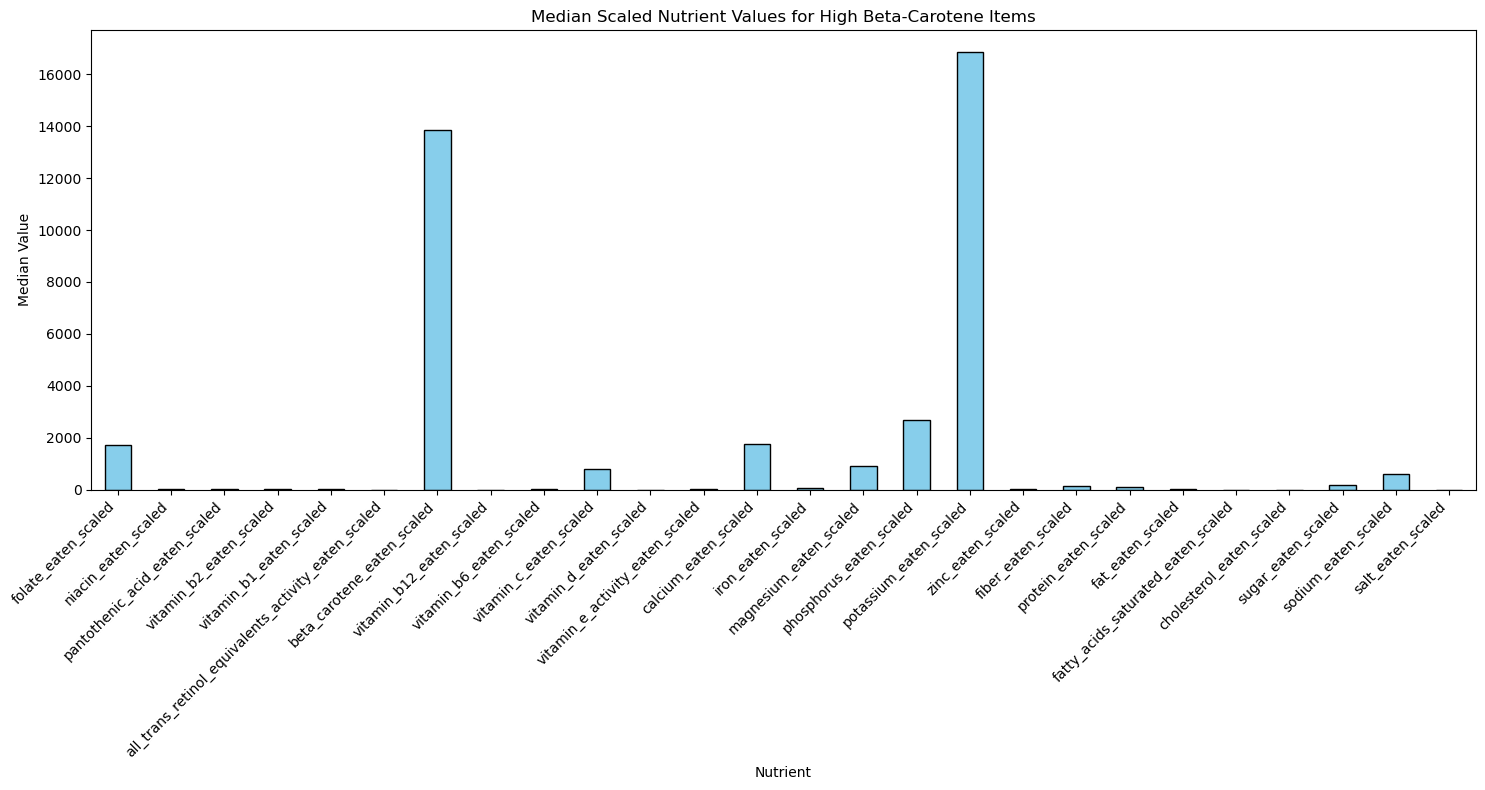

In [82]:
aggregated_values = a.median()

plt.figure(figsize=(15, 8))
aggregated_values.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Median Scaled Nutrient Values for High Beta-Carotene Items')
plt.xlabel('Nutrient')
plt.ylabel('Median Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

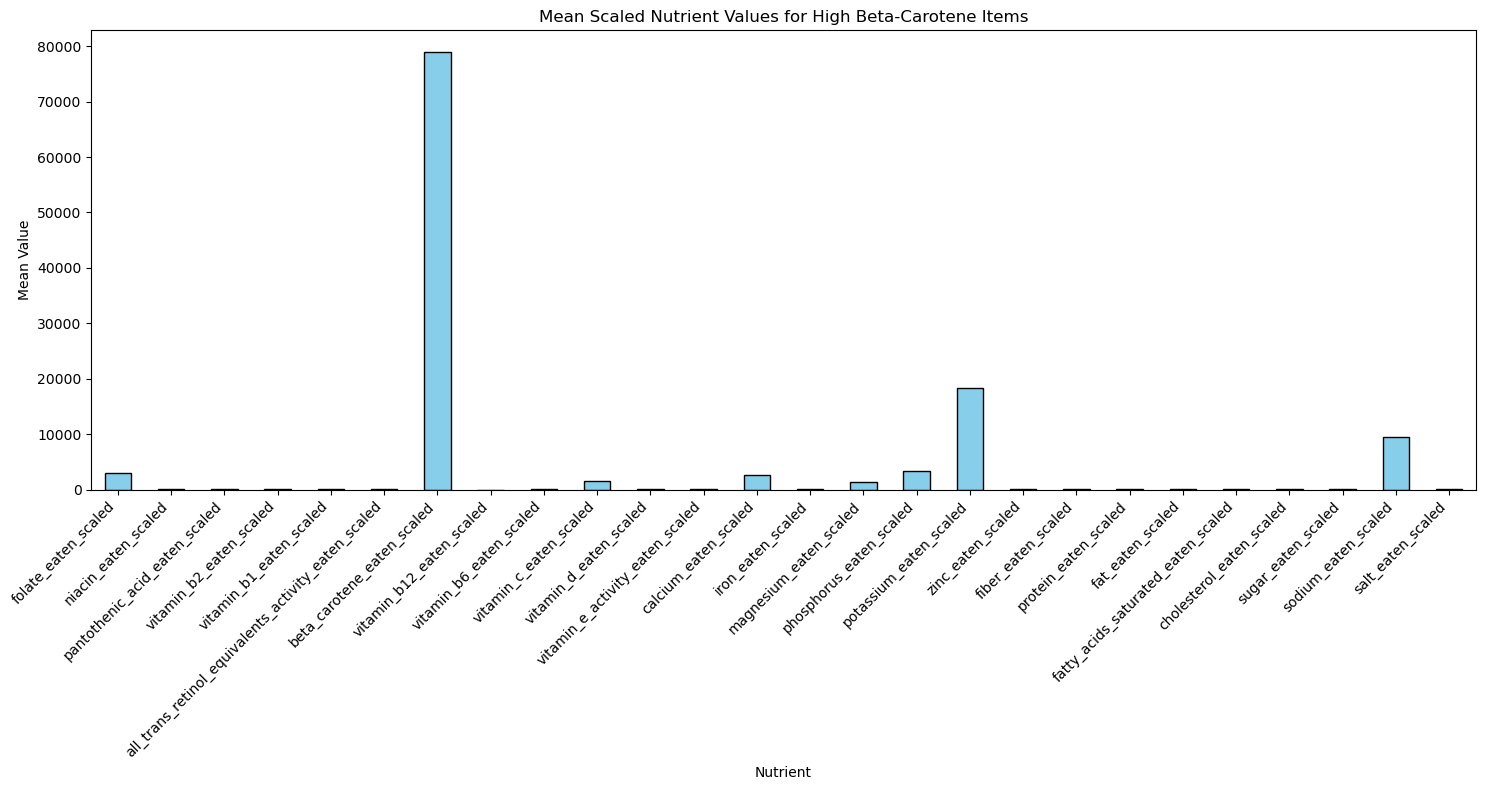

In [83]:
aggregated_values = a.mean() 

plt.figure(figsize=(15, 8))
aggregated_values.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Mean Scaled Nutrient Values for High Beta-Carotene Items')
plt.xlabel('Nutrient')
plt.ylabel('Mean Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()